In [1]:
# grid search ARIMA parameters for a time series
import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

/home/kranthidr/.virtualenvs/tml-lab/lib64/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/kranthidr/.virtualenvs/tml-lab/lib64/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/kranthidr/.virtualenvs/tml-lab/lib64/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/kranthidr/.virtualenvs/tml-lab/lib64/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/kranthidr/.virtualenvs/tml-lab/lib64/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96

In [2]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        # model_fit = model.fit(disp=0)
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [3]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [4]:
# load dataset
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)

In [5]:
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 1) RMSE=282.656
ARIMA(0, 0, 4) RMSE=77.297
ARIMA(0, 1, 1) RMSE=21.907
ARIMA(0, 1, 2) RMSE=22.182
ARIMA(0, 1, 3) RMSE=24.733
ARIMA(0, 1, 4) RMSE=24.845
ARIMA(0, 2, 1) RMSE=22.381
ARIMA(0, 2, 2) RMSE=22.244
ARIMA(1, 0, 0) RMSE=21.996
ARIMA(1, 1, 0) RMSE=21.922
ARIMA(1, 2, 0) RMSE=27.464
ARIMA(1, 2, 1) RMSE=22.271
ARIMA(2, 1, 0) RMSE=21.733
ARIMA(2, 2, 0) RMSE=25.282
ARIMA(3, 1, 0) RMSE=24.270
ARIMA(3, 1, 1) RMSE=25.491
ARIMA(3, 2, 0) RMSE=25.625
ARIMA(3, 2, 1) RMSE=25.008
ARIMA(4, 0, 0) RMSE=25.258
ARIMA(4, 1, 0) RMSE=24.802
ARIMA(4, 1, 1) RMSE=25.103
ARIMA(4, 2, 0) RMSE=27.089
ARIMA(4, 2, 1) RMSE=25.933
ARIMA(4, 2, 2) RMSE=25.418
Best ARIMA(2, 1, 0) RMSE=21.733


In [6]:
# summarize residual errors for an ARIMA model
from pandas import DataFrame
# load data
# prepare data
X = series.values
X = X.astype('float32')

In [7]:
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

In [8]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)

In [9]:
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())

               0
count  35.000000
mean    1.081624
std    22.022566
min   -52.103811
25%   -16.202284
50%    -0.459805
75%    12.085091
max    51.284339


In [10]:
from matplotlib import pyplot

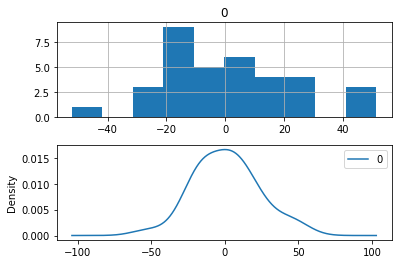

In [11]:
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

In [12]:
# summarize residual errors from bias corrected forecasts
# load data
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

In [13]:
# walk-forward validation
history = [x for x in train]
predictions = list()
bias = 1.081624

In [14]:
for i in range(len(test)):
    # predict
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = bias + float(model_fit.forecast()[0])
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    

In [15]:
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

RMSE: 21.706


In [16]:
# summarize residual errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)

In [17]:
residuals.describe()

,0
count,3.500000e+01
mean,2.700567e-07
std,2.202257e+01
min,-5.318543e+01
25%,-1.728391e+01
50%,-1.541429e+00
75%,1.100347e+01
max,5.020272e+01


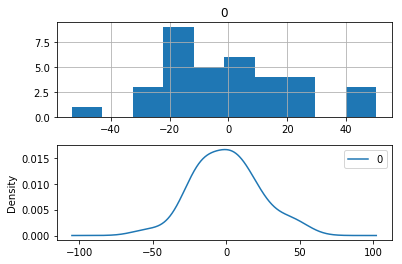

In [18]:
# plot residual errors
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()